# Tutorial: Structural Comparisons

## Introduction

For this tutorial, we are interested in understanding differences in two organizational structures. Organizations are made of multiple components, which can be linked together in different ways. The organization can include an operational unit (S1), coordination unit (S2), resource allocation unit (S3), situational awareness unit (S4), and overall policy setting unit (S5). These components within organizations could have well-defined roles and responsibilities, with clear feedback between components (i.e., "tightly structured"). Organizations can also be more loosely structured, with relatively little connection between components. Below is an example of how these two types of organizations could be laid out, with more feedback present within the tightly structured organization. We also include a possible outside influence ("Att") and the environment ("Env") interacting with the organization.

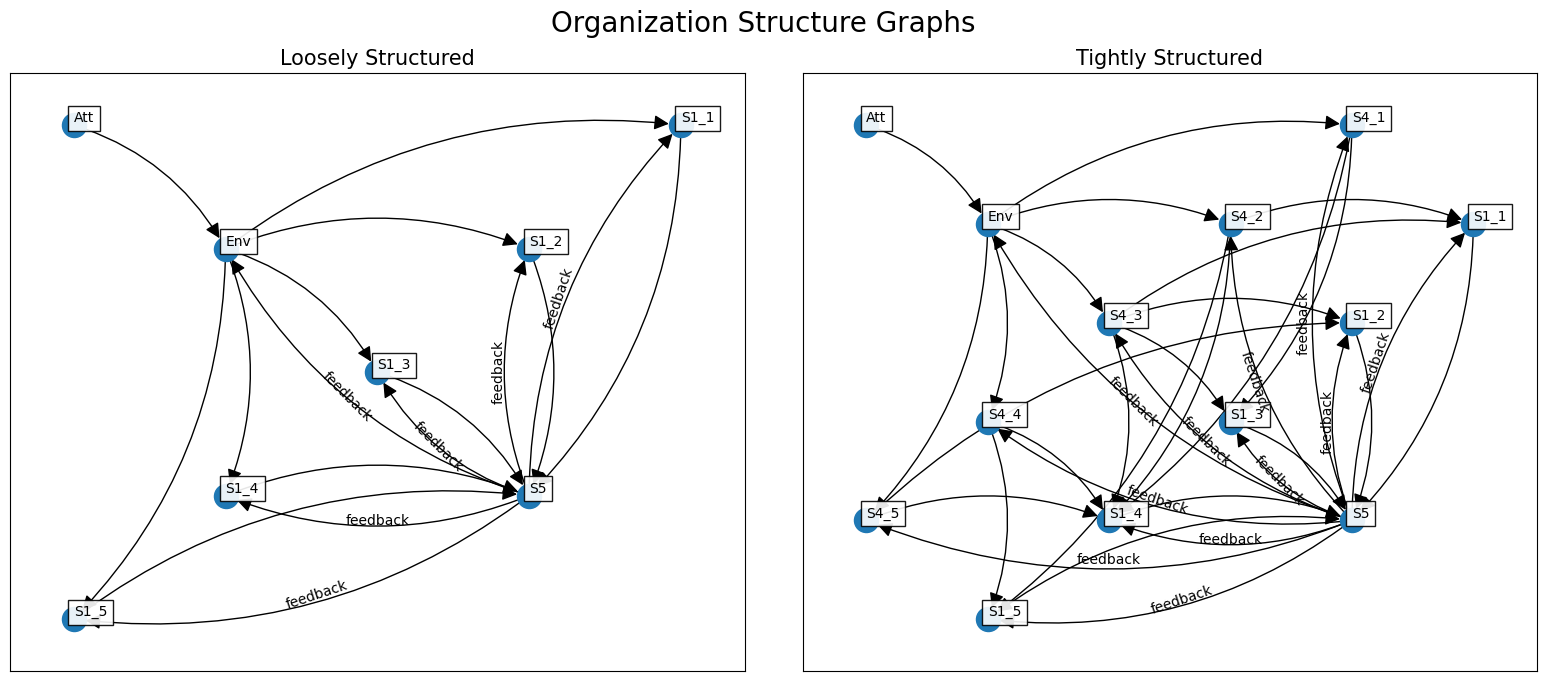

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

graphs = {}
graphs["Loosely Structured"] = nx.read_gexf("complex_loose_struct.gexf")
graphs["Tightly Structured"] = nx.read_gexf("complex_tight_struct.gexf")

def edge_label_pos_angle(src_pos, dest_pos, rad=0):
    sx, sy = src_pos
    dx, dy = dest_pos
    
    diff_x, diff_y = dx - sx, dy - sy
    cx, cy = (dx + sx) / 2, (dy + sy) / 2
    position = cx - diff_y * rad *.5, cy + diff_x * rad * .5
    angle = 180 * math.atan2(diff_y, diff_x) / math.pi
    if angle > 90 or angle < -90:
        angle += 180
    return position, angle

def draw(graph, ax, title="", rad=.17):
    num_nodes = len(graph)
    x_vals = nx.get_node_attributes(graph, "x")
    y_vals = nx.get_node_attributes(graph, "y")
    pos = {k:(x_vals[k], y_vals[k]) for k in graph.nodes()}
    ax.set_title(title)
    ax.title.set_size(15)
    edge_labels={(u, v): d["label"] for u, v, d in graph.edges(data=True) if "label" in d}
    nx.draw_networkx(
        graph,
        pos=pos,
        ax=ax,
        with_labels=True,
        font_size=10,
        horizontalalignment="left",
        verticalalignment="bottom",
        bbox=dict(facecolor='white', alpha=0.9),
        node_shape="o",
        arrowsize=22,
        connectionstyle="arc3,rad=-" + str(rad)
    )
    for edge, label in edge_labels.items():
        u, v = edge
        edge_pos, edge_angle = edge_label_pos_angle(pos[u], pos[v], rad)
        x, y = edge_pos
        ax.text(x, y, label, horizontalalignment='center', verticalalignment='center', rotation=edge_angle)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Organization Structure Graphs', y=1.0, size=20)
fig.tight_layout()
for title, ax in zip(graphs, (ax1, ax2)):
    draw(graphs[title], ax, title, rad=.2)

These two organizations vary in the number of nodes and edges present.

In [6]:
print("Numbers of Nodes:")
for title, graph in graphs.items():
    print(title + ":", len(graph))
    
print("Numbers of Edges:")
for title, graph in graphs.items():
    print(title + ":", len(graph.edges))    

Numbers of Nodes:
Loosely Structured: 8
Tightly Structured: 13
Numbers of Edges:
Loosely Structured: 17
Tightly Structured: 35


## Implementation of Metrics

Metrics within pyRoCS can be implemented to help quantify possible differences between the two organizational structures. Below, we step through how three of these metrics are used to understand complexity of the organizational structures.

## Cyclomatic Complexity
There are different ways that we can measure the structure of an organization. These include counting the number of components (i.e., nodes) and connections between them (i.e, edges). However, to understand the number of linearly independent paths that are present within the organizations, it is helpful to actually combine these two numbers into an overall cyclomatic complexity score. 

In [2]:
from pyrocs.complex_systems import cyclomatic_complexity as cyc_comp

print("Cyclomatic Complexity")
for title, graph in graphs.items():
    print(title + ":", cyc_comp(nx.to_numpy_array(graph)))

Cyclomatic Complexity
Loosely Structured: 6.0
Tightly Structured: 19.0


The cyclomatic complexity score demonstrates how there are significantly more feedback loops or connections within the tightly structured organization.

## Discrete Entropy

In addition to looking at the overall connectivity, we can also characterize the relative diversity of components within the organization (i.e., distribution of S1s, S4s, etc). 

In [8]:
import pyrocs.information_theory as info

def node_type_entropy(graph):
    types = [d["type"] for _, d in graph.nodes(data=True)]
    return info.discrete_entropy(types)
    
print("Entropy of Node Type")
for title, graph in graphs.items():
    print(title + ":", round(node_type_entropy(graph),2))

Entropy of Node Type
Loosely Structured: 1.55
Tightly Structured: 1.91


The discrete entropy score indicates that there is a more even distribution of node types within the tightly structured organization (i.e., high counts of both S1 and S4) whereas the loosely structured organization only has one component that repeats (S1).

## Functional Redundancy

Functional Redundancy, which measures the expected mean similarity of two randomly drawn elements, can be used to evaluate how much redundancy there is between nodes. For the purposes of this example, nodes are considered similar if they are the same type of component pointed to the same outgoing component and fully different if they are different components. 

In [10]:
from pyrocs.biosciences import functional_redundancy

def jaccard_index(a, b):
    if not a and not b:
        return 1
    a = set(a)
    b = set(b)
    return len(a.intersection(b)) / len(a.union(b))

def dissimilarity(graph, node_a, node_b):
    """Computes dissimilarity between two nodes.
    Returns 1 for nodes of different types, otherwise returns
    the Jaccard Distance between the sets of outgoing neighbors
    """
    a_type = graph.nodes[node_a].get("type")
    b_type = graph.nodes[node_a].get("type")
    if a_type != b_type:
        return 1
    a_neighbors = list(graph.out_edges(node_a))[0]
    b_neighbors = list(graph.out_edges(node_b))[0]
    return 1 - jaccard_index(a_neighbors, b_neighbors)
    
def fr(graph):
    nodes = list(graph)
    num_nodes = len(nodes)
    delta = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            delta[i, j] = dissimilarity(graph, nodes[i], nodes[j])
    p = np.array([1/num_nodes] * num_nodes)
    return functional_redundancy(p, delta)
    
print("Functional Redundancy")
for title, graph in graphs.items():
    print(title + ":", round(fr(graph),2))

Graph Functional Redundancy
Loosely Structured: 0.23
Tightly Structured: 0.11


The functional redundancy score indicates that there is actually more redundancy within the loosely structured organization. This is stemming from the similar roles of S1s translating information from the environment directly to S5. In contrast, the tightly structured organization has a lot more variability in which components are connected together (i.e., which S4s interact with which S1s), thus leading to a lower functional redundancy score.